In [1]:
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt

X = pkl.load(open('./data/X_processed.pkl', 'rb'))
y = pkl.load(open('./data/y_processed.pkl', 'rb'))

print(X.shape, y.shape)

((6502, 3, 12), (6502,))


In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

training_size = 6000

X_train = X[:training_size]
y_train = y[:training_size]

X_test = X[training_size:]
y_test = y[training_size:]

X_train = X_train.reshape((X_train.shape[0], -1))
X_test = X_test.reshape((X_test.shape[0], -1))

classifier = RandomForestClassifier()
y_pred = classifier.fit(X_train, y_train).predict(X_test)

accuracy_score(y_test, y_pred)

0.92031872509960155

In [3]:
noise = np.random.normal(0, 1, 600)
plt.hist(noise, bins=30)
print(np.where(abs(noise)<0.01))

(array([ 29, 287, 290, 361, 392]),)


In [4]:
#directory = './output/2.0_0.001_200_0.002_100/'
#directory = './output/4.0_0.0001_500_0.002_100/'
directory = './output/p0_8.0_0.0001_500_0.002_100/'

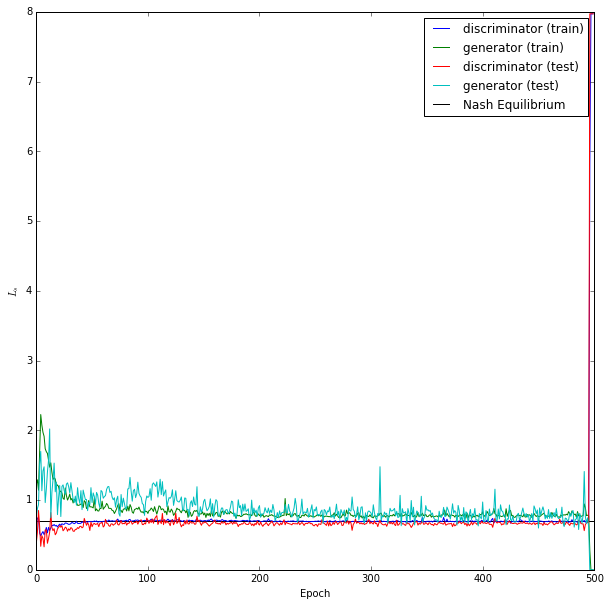

In [5]:
import h5py
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
plt.figure(figsize=(10,10))

hist = pkl.load(open(directory + 'acgan-history.pkl', 'rb'))
losses = ['loss', 'generation_loss', 'auxiliary_loss']

for p in ['train', 'test']:
    for g in ['discriminator', 'generator']:
        hist[p][g] = pd.DataFrame(hist[p][g], columns=losses)

for p in ['train', 'test']:
    for g in ['discriminator', 'generator']:
        plt.plot(hist[p][g]['generation_loss'], label='{} ({})'.format(g, p))

# get the NE and show as an equilibrium point
plt.hlines(-np.log(0.5), 0, hist[p][g]['generation_loss'].shape[0], label='Nash Equilibrium')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel(r'$L_s$')

plt.show()

# for p in hist['privacy']:
#     print(p)

In [6]:
print(hist['privacy'][-1])

[EpsDelta(spent_eps=0.125, spent_delta=1.0), EpsDelta(spent_eps=0.25, spent_delta=0.888008684238965), EpsDelta(spent_eps=0.5, spent_delta=0.4905471793485281), EpsDelta(spent_eps=1, spent_delta=0.03615517596002047), EpsDelta(spent_eps=2, spent_delta=6.839430885772871e-07), EpsDelta(spent_eps=4, spent_delta=3.8614944663482357e-26), EpsDelta(spent_eps=8, spent_delta=2.7255174089969415e-103)]


# Transfer Learning

In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

acgan = __import__('ac_gan')

from glob import glob
from keras.models import load_model
from sklearn import linear_model

latent_size = 100


lr_clf = linear_model.LogisticRegression()
transfer_clf = RandomForestClassifier()

mean_scores = []
lr_scores = []
directory = './output/p' + str(9) + '_8.0_0.0001_500_0.002_100/'
# directory = './output/acgan_500_0.0002_100/'

for i in range(0, 500):
    gen_name = sorted(glob(directory + 'params_generator*'))[i]
    print(gen_name)
    g = load_model(gen_name)

    generate_count = training_size

    noise = np.random.uniform(-1, 1, (generate_count, latent_size))
    sampled_labels = np.random.randint(0, 2, generate_count)
    generated_images = g.predict([noise, sampled_labels.reshape((-1, 1))], verbose=0)

    gen_X_train = np.reshape(generated_images, (training_size, 3, 12))
    gen_X_train = gen_X_train.astype(int)
    gen_X_train = gen_X_train.clip(min=0)

    gen_X_train = gen_X_train.reshape(generate_count, -1)
    gen_y_train = sampled_labels


    mean_scores.append(accuracy_score(y_test, transfer_clf.fit(gen_X_train, gen_y_train).predict(X_test)))
    lr_scores.append(accuracy_score(y_test, lr_clf.fit(gen_X_train, gen_y_train).predict(X_test)))
pkl.dump({'rf': mean_scores, 'lr': lr_scores}, open(directory + 'epoch_scores.p', 'wb'))

Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.
./output/p9_8.0_0.0001_500_0.002_100/params_generator_epoch_000.h5
./output/p9_8.0_0.0001_500_0.002_100/params_generator_epoch_001.h5
./output/p9_8.0_0.0001_500_0.002_100/params_generator_epoch_002.h5
./output/p9_8.0_0.0001_500_0.002_100/params_generator_epoch_003.h5
./output/p9_8.0_0.0001_500_0.002_100/params_generator_epoch_004.h5
./output/p9_8.0_0.0001_500_0.002_100/params_generator_epoch_005.h5
./output/p9_8.0_0.0001_500_0.002_100/params_generator_epoch_006.h5
./output/p9_8.0_0.0001_500_0.002_100/params_generator_epoch_007.h5
./output/p9_8.0_0.0001_500_0.002_100/params_generator_epoch_008.h5
./output/p9_8.0_0.0001_500_0.002_100/params_generator_epoch_009.h5
./output/p9_8.0_0.0001_500_0.002_100/params_generator_epoch_010.h5
./output/p9_8.0_0.0001_500_0.002_100/params_generator_epoch_011.h5
./output/p9_8.0_0.0001_500_0.002_100/params_generator_epoch_012.h5
./output/p9_8.0_0.0001_500_0.002_100/params_generator_epoc

In [16]:
print(lr_scores)
print(max(lr_scores))
print(np.argmax(lr_scores))
print(lr_scores[np.argmax(lr_scores)])

[0.60756972111553786, 0.51992031872509958, 0.60557768924302791, 0.54382470119521908, 0.51394422310756971, 0.52191235059760954, 0.57370517928286857, 0.39641434262948205, 0.41434262948207173, 0.47410358565737054, 0.51792828685258963, 0.55976095617529875, 0.65936254980079678, 0.62350597609561753, 0.56972111553784865, 0.51792828685258963, 0.61952191235059761, 0.62350597609561753, 0.67529880478087645, 0.50796812749003983, 0.72310756972111556, 0.74900398406374502, 0.77490039840637448, 0.74701195219123506, 0.71912350597609564, 0.74701195219123506, 0.67928286852589637, 0.57968127490039845, 0.73306772908366535, 0.74900398406374502, 0.69322709163346619, 0.73306772908366535, 0.7211155378486056, 0.77091633466135456, 0.71513944223107573, 0.78685258964143423, 0.76693227091633465, 0.69322709163346619, 0.75298804780876494, 0.74302788844621515, 0.70916334661354585, 0.73705179282868527, 0.65936254980079678, 0.6972111553784861, 0.60358565737051795, 0.72509960159362552, 0.72709163346613548, 0.770916334661

In [17]:
print(mean_scores)
print(max(mean_scores))
print(np.argmax(mean_scores))
print(mean_scores[np.argmax(mean_scores)])

[0.68127490039840632, 0.50796812749003983, 0.5677290836653387, 0.66135458167330674, 0.52788844621513942, 0.41633466135458169, 0.34063745019920316, 0.30876494023904383, 0.44023904382470119, 0.45219123505976094, 0.53585657370517925, 0.54183266932270913, 0.67131474103585653, 0.53187250996015933, 0.51593625498007967, 0.68525896414342624, 0.67729083665338641, 0.6972111553784861, 0.62549800796812749, 0.7450199203187251, 0.78486055776892427, 0.75099601593625498, 0.69521912350597614, 0.78685258964143423, 0.79083665338645415, 0.75697211155378485, 0.67131474103585653, 0.74900398406374502, 0.7689243027888446, 0.78486055776892427, 0.74701195219123506, 0.57968127490039845, 0.73306772908366535, 0.83466135458167334, 0.82669322709163351, 0.82071713147410363, 0.7310756972111554, 0.79681274900398402, 0.75697211155378485, 0.74900398406374502, 0.77689243027888444, 0.72709163346613548, 0.81075697211155373, 0.7689243027888446, 0.63745019920318724, 0.80079681274900394, 0.79681274900398402, 0.8127490039840638

In [18]:
gen_name = sorted(glob(directory + 'params_generator*'))[np.argmax(lr_scores)]
print(gen_name)
g = load_model(gen_name)

generate_count = training_size

noise = np.random.uniform(-1, 1, (generate_count, latent_size))
sampled_labels = np.random.randint(0, 2, generate_count)
generated_images = g.predict([noise, sampled_labels.reshape((-1, 1))], verbose=0)

#     print(generated_images.shape)
gen_X_train = np.reshape(generated_images, (training_size, 3, 12))

#     print(np.max(gen_X_train))
#     print(np.min(gen_X_train))

for i in range(gen_X_train.shape[0]):
    gen_X_train[i][0] = gen_X_train[i][0] 
    gen_X_train[i][1] = gen_X_train[i][1] 
    gen_X_train[i][2] = gen_X_train[i][2]

gen_X_train = gen_X_train.astype(int)
gen_X_train = gen_X_train.clip(min=0)
#     print(gen_X_train[:2])
#     print(gen_X_train.shape)

gen_X_train = gen_X_train.reshape(generate_count, -1)
#     print(gen_X_train.shape)

gen_y_train = sampled_labels

unique, counts = np.unique(y_train, return_counts=True)
#     print('real' + str(dict(zip(unique, counts))))

unique, counts = np.unique(gen_y_train, return_counts=True)
#     print('gen' + str(dict(zip(unique, counts))))

#     print(gen_X_train.shape)
#     print(gen_y_train.shape)

from sklearn.model_selection import cross_val_score

transfer_clf = RandomForestClassifier()
scores = cross_val_score(transfer_clf, gen_X_train, gen_y_train, cv=5)
print(scores)

score_list = []
for i in range(5):
    gen_y_pred = transfer_clf.fit(gen_X_train, gen_y_train).predict(X_test)
    score_list.append(accuracy_score(y_test, gen_y_pred))
print(score_list)
print(np.mean(score_list))

./output/p0_8.0_0.0001_500_0.002_100/params_generator_epoch_364.h5
[ 1.          0.99416667  0.99083333  0.99666667  0.9975    ]
[0.91035856573705176, 0.89442231075697209, 0.9083665338645418, 0.90239043824701193, 0.92031872509960155]
0.907171314741


# PCA plot

(12000, 36)
[ 0.37819901  0.17576383]


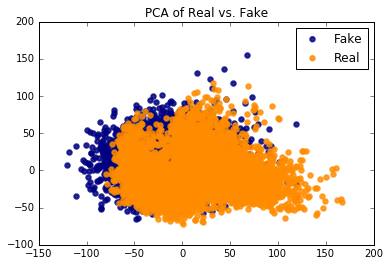

In [19]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

X_pca = np.concatenate((gen_X_train, X_train))
print(X_pca.shape)

y = np.array([1] * generate_count + [0] * training_size)
pca = PCA(n_components=2)
X_r = pca.fit(X_pca).transform(X_pca)

target_names = ['Fake', 'Real']
colors = ['navy', 'darkorange']
lw = 2

for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)

plt.title('PCA of Real vs. Fake')

print(pca.explained_variance_ratio_)

(1000, 36)


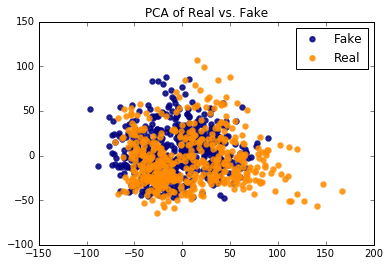

In [20]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

plot_count = 500
X_pca = np.concatenate((gen_X_train[:plot_count], X_train[:plot_count]))
print(X_pca.shape)

y = np.array([1] * plot_count + [0] * plot_count)

pca = PCA(n_components=2)
X_r = pca.fit(X_pca).transform(X_pca)

target_names = ['Fake', 'Real']
colors = ['navy', 'darkorange']
lw = 2

for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)

plt.title('PCA of Real vs. Fake')

# Real vs. Fake

In [22]:
clf =  RandomForestClassifier()

X_comb = np.concatenate((gen_X_train, X_train))
y = np.array([1] * generate_count + [0] * training_size)

print(X_comb.shape, y.shape)
scores = cross_val_score(clf, X_comb, y, cv=5)
print(scores)

from sklearn.neighbors import KNeighborsClassifier
nn_clf = KNeighborsClassifier(n_neighbors=9)

scores = cross_val_score(nn_clf, X_comb, y, cv=5)
print(scores)

((12000, 36), (12000,))
[ 0.89458333  0.88708333  0.89416667  0.90166667  0.88833333]
[ 0.78458333  0.79458333  0.78583333  0.77583333  0.77541667]
